# Classification of Mutagenic Compounds

## Introduction


Mutagens are chemical compounds that cause irreversible and heritable changes or mutations in the DNA of cells. This causes an increased probability and frequency of mutations above the natural level [1]. Furthermore, since they directly alter the DNA and the information within it, it can cause aberrant, impaired or loss of function for a particular gene, and accumulation of mutations may lead to cancer [2]. 


The mutagenicity of compounds is a key component to identify in drug design and new compound design. QSPR data was collected by the Machine Learning in Chemical Engineering team and then analysed with multiple classification models to determine whether a molecule is mutagenic[3-4].

In this notebook, 4 classification models will be implemented to see which has the better performance. The models chosen are: Logistic Regression, k-Nearest neighbours (k-NN), Random Forests, and Extreme Gradient Boost (XGB). Logistic Regression was chosen for its simplicity, robustness, and ease of implementation. kNN was chosen as there is a hypothesis that molecules with similar parameters have similar behaviours. Random forests and XGB were chosen because they have proven to be the best classification algorithms in the machine learning industry [5].

These models will be evaluated with 4 metrics: Accuracy, Precision, Recall, and F1 score. Furthermore, the dataset has a "predicted value" which is a binary value indicating whether the compound is mutagenic or not based upon the VEGA model. This model uses multiple QSAR (Quantitative Structure-Activity Relationship) model techniques to detect multiple toxicological properties of compounds [6]. The accuracy of the models will be compared to the VEGA model to see its performances compared to one of the best published models in detecting toxicological properties of compounds. 

## Library and data imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay) 


sns.set_style("darkgrid")

## Initial EDA

Data acquired from 

[7] E. I. Sanchez Medina, A. del Rio Chanona, and C. Ganzer, Machine Learning in Chemical Engineering. JupyterBook, 2023. 

In [2]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/mutagenicity_kNN.csv")

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5764 non-null   int64  
 1   Id                   5764 non-null   int64  
 2   CAS                  5764 non-null   object 
 3   SMILES               5764 non-null   object 
 4   Status               5764 non-null   object 
 5   Experimental value   5764 non-null   int64  
 6   Predicted value      5764 non-null   object 
 7   NumValenceElectrons  5764 non-null   int64  
 8   qed                  5764 non-null   float64
 9   TPSA                 5764 non-null   float64
 10  MolMR                5764 non-null   float64
 11  BalabanJ             5764 non-null   float64
 12  BertzCT              5764 non-null   float64
 13  MolWt                5764 non-null   float64
 14  MolLogP              5764 non-null   float64
dtypes: float64(7), int64(4), object(4)
mem

In [4]:
raw_data.describe()

,Unnamed: 0,Id,Experimental value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
count,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000
mean,2881.500000,2885.997224,0.564018,86.975885,0.514007,53.769226,65.054749,2.573714,520.170632,241.124045,2.585628
std,1664.067807,1666.594934,0.495928,42.616094,0.165847,43.060851,30.791044,0.640978,378.132827,116.086247,1.938946
min,0.000000,1.000000,0.000000,10.000000,0.016502,0.000000,3.929500,0.854053,0.000000,28.010000,-13.262400
25%,1440.750000,1442.750000,0.000000,60.000000,0.401531,26.020000,43.242600,2.131210,227.914524,165.171750,1.342550
50%,2881.500000,2885.500000,1.000000,82.000000,0.513235,46.170000,62.158050,2.480737,460.103244,228.207000,2.463200
75%,4322.250000,4329.250000,1.000000,104.000000,0.626174,72.322500,81.738375,2.953223,748.111589,290.531250,3.751620
max,5763.000000,5771.000000,1.000000,490.000000,0.924384,633.360000,328.444600,6.947594,5033.685325,1550.188000,17.853900


In [5]:
raw_data.head()

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,100-00-5,O=[N+]([O-])c1ccc(cc1)Cl,Training,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.2482
1,1,2,100-01-6,O=[N+]([O-])c1ccc(N)cc1,Training,1,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.1770
2,2,3,100-02-7,O=[N+]([O-])c1ccc(O)cc1,Training,0,1,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.3004
3,3,4,100-11-8,O=[N+]([O-])c1ccc(cc1)CBr,Training,1,0,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.4897
4,4,5,100-12-9,O=[N+]([O-])c1ccc(cc1)CC,Training,0,0,58,0.479785,43.14,42.4744,2.913802,253.299498,151.165,2.1572


Checking for any duplicates, CAS number is a unique ID for every molecule

In [6]:
len(raw_data['CAS'])-len(raw_data['CAS'].drop_duplicates())

0

In [7]:
raw_data['Predicted value'].value_counts()

Predicted value
1                3309
0                2449
Non Predicted       6
Name: count, dtype: int64

In [8]:
raw_data.isna().sum()

Unnamed: 0             0
Id                     0
CAS                    0
SMILES                 0
Status                 0
Experimental value     0
Predicted value        0
NumValenceElectrons    0
qed                    0
TPSA                   0
MolMR                  0
BalabanJ               0
BertzCT                0
MolWt                  0
MolLogP                0
dtype: int64

There are no missing values across the dataframe. Also the "predicted value" column seems to have a non predicted value, this will be removed and turned into a binary variable that will be used later on

In [9]:
data = raw_data.copy()
data = data[data['Predicted value'] != 'Non Predicted']

data['Predicted value'] = data['Predicted value'].astype(int)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5758 entries, 0 to 5763
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5758 non-null   int64  
 1   Id                   5758 non-null   int64  
 2   CAS                  5758 non-null   object 
 3   SMILES               5758 non-null   object 
 4   Status               5758 non-null   object 
 5   Experimental value   5758 non-null   int64  
 6   Predicted value      5758 non-null   int32  
 7   NumValenceElectrons  5758 non-null   int64  
 8   qed                  5758 non-null   float64
 9   TPSA                 5758 non-null   float64
 10  MolMR                5758 non-null   float64
 11  BalabanJ             5758 non-null   float64
 12  BertzCT              5758 non-null   float64
 13  MolWt                5758 non-null   float64
 14  MolLogP              5758 non-null   float64
dtypes: float64(7), int32(1), int64(4), object(3

Checking the experimental value (target varaible) distribution to determine if it's a balanced dataset

In [11]:
data['Experimental value'].value_counts()/data.shape[0]*100

Experimental value
1    56.425842
0    43.574158
Name: count, dtype: float64

In [46]:
def calc_VEGA_accuracy(df: pd.DataFrame):
    df['true_positive'] = df['Predicted value'] == df['Experimental value']
    
    acc = df['true_positive'].sum() / df.shape[0]
    
    return acc


VEGA_accuracy = calc_VEGA_accuracy(data)

VEGA_accuracy * 100

79.99305314345258

The dataset seems balanced enough with a 56-44 split between mutagenic molecules.

Feature distribution

In [13]:
# removing non important columns
df = data.drop(['Unnamed: 0', 'Id','CAS','SMILES','Status','Predicted value'],axis=1)

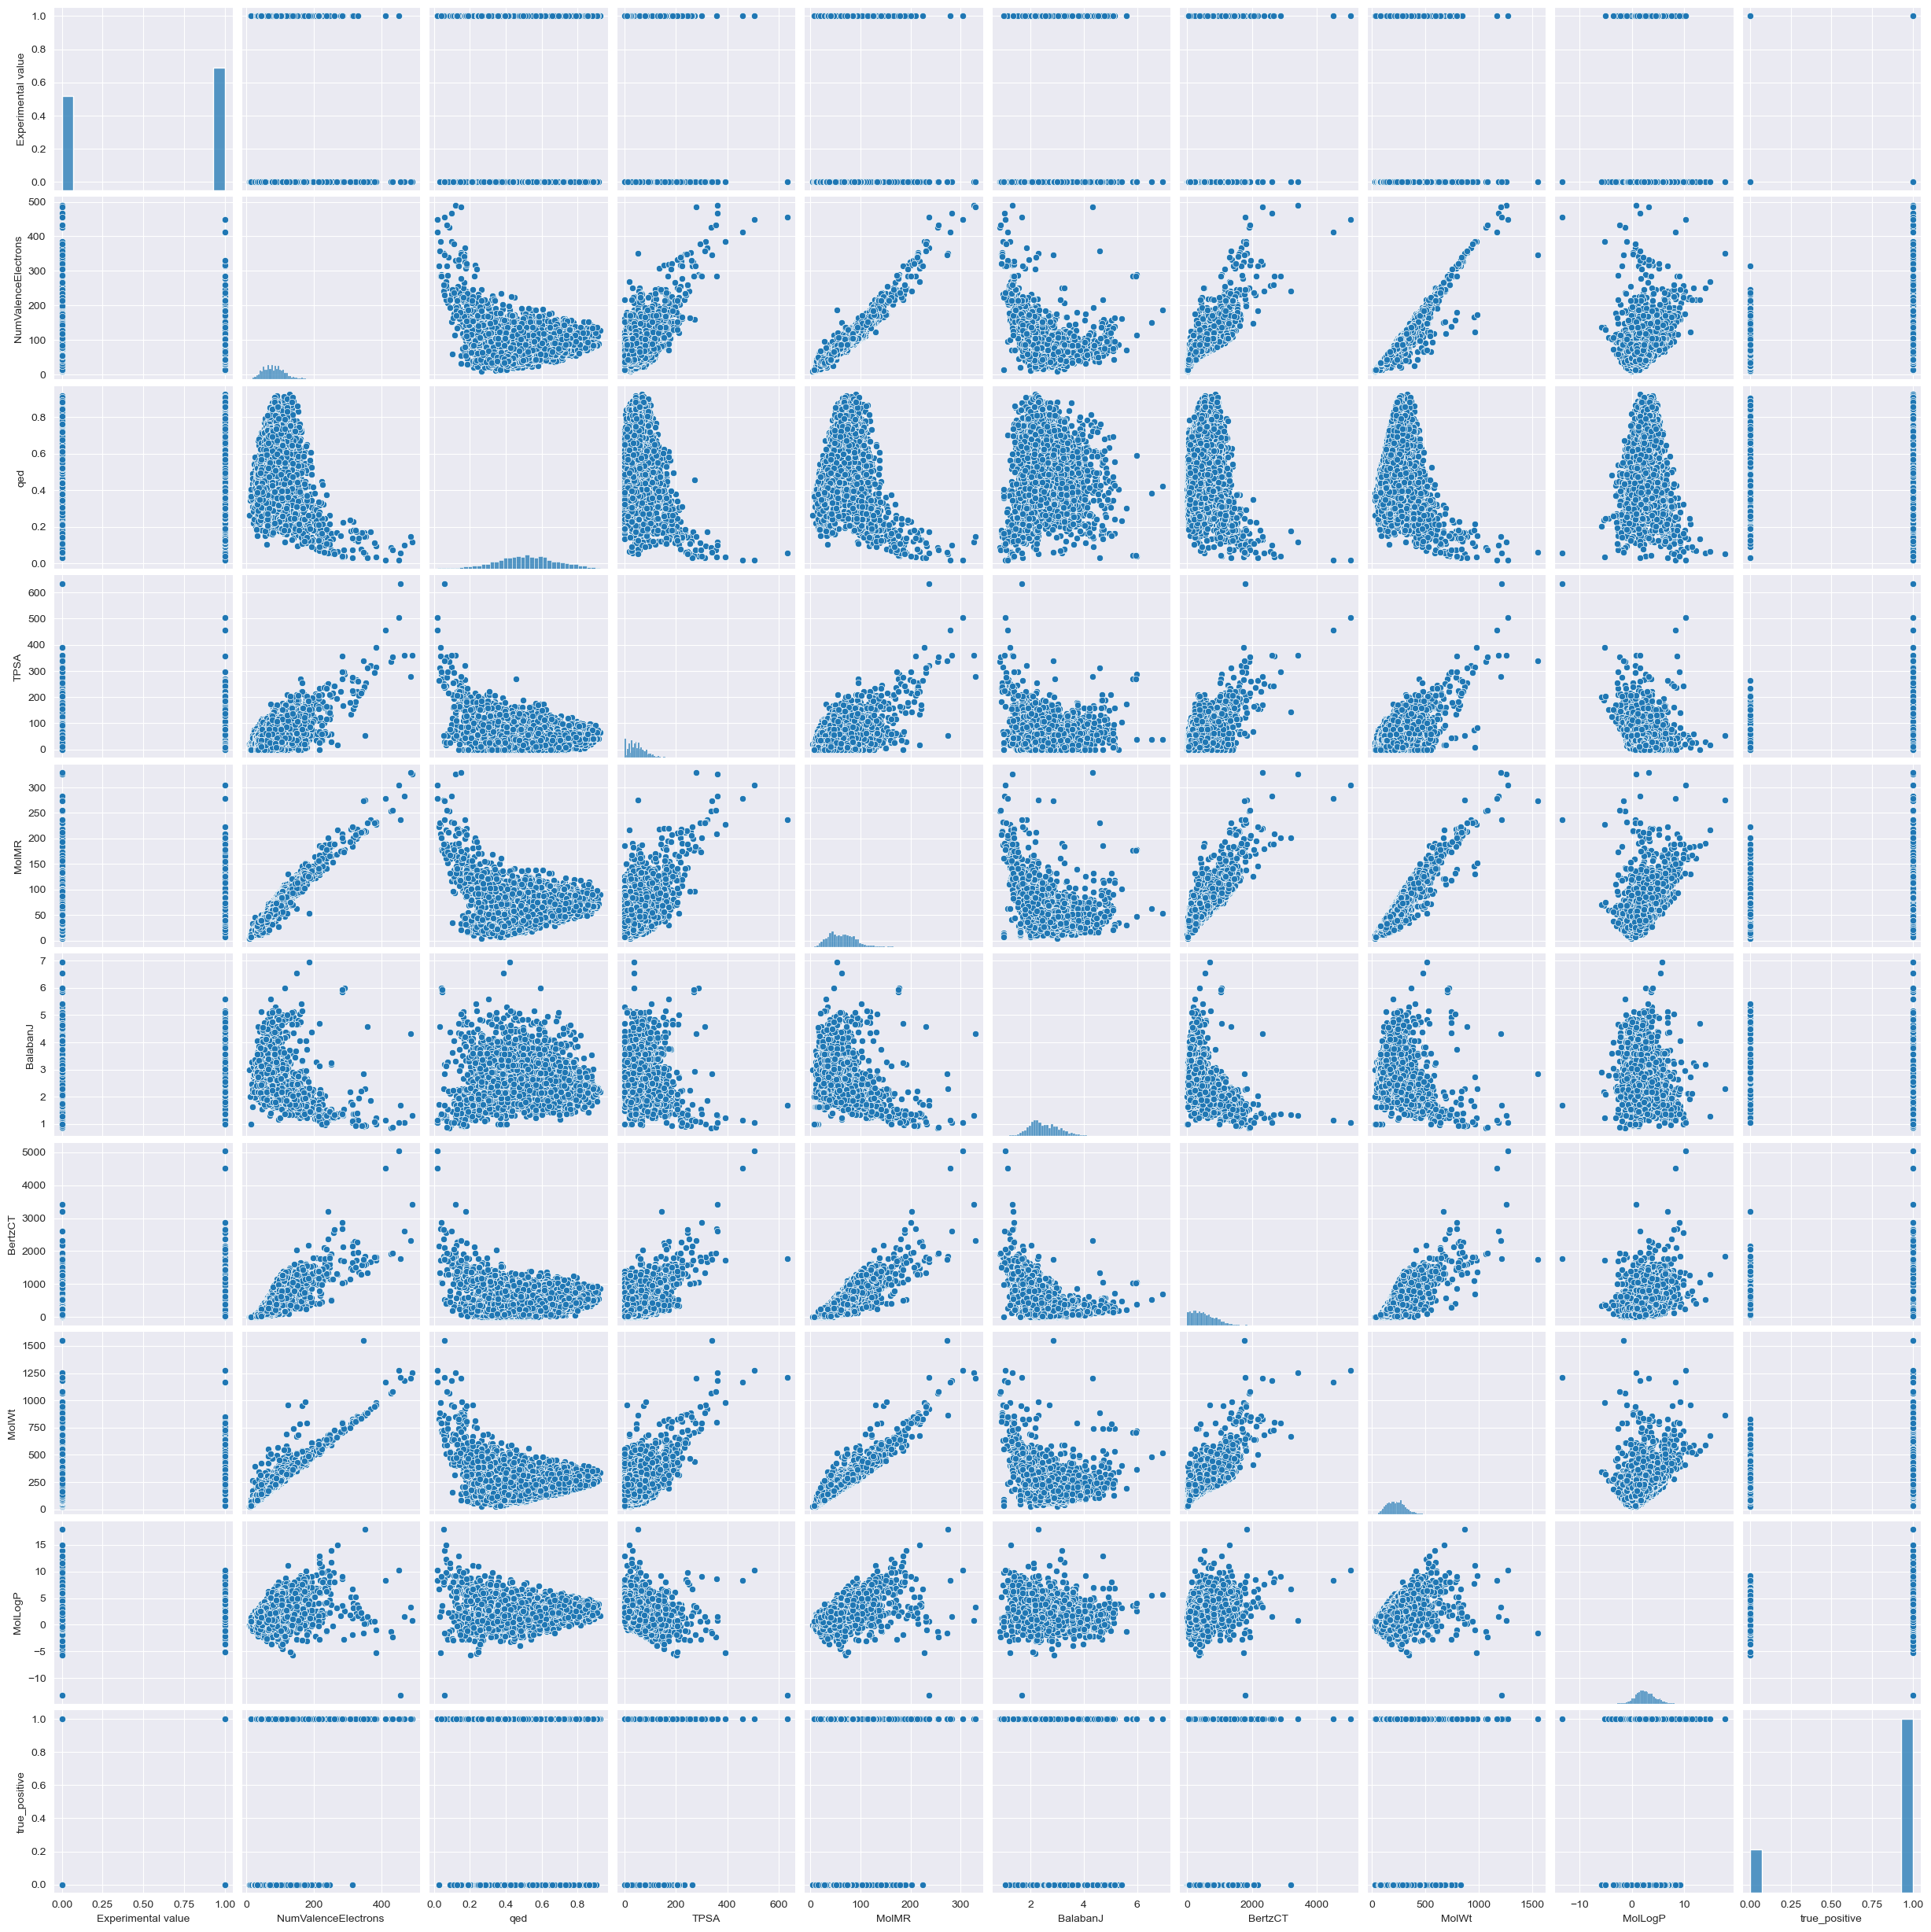

In [14]:
sns.pairplot(df)

## Data preparation for classification models

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5758 entries, 0 to 5763
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Experimental value   5758 non-null   int64  
 1   NumValenceElectrons  5758 non-null   int64  
 2   qed                  5758 non-null   float64
 3   TPSA                 5758 non-null   float64
 4   MolMR                5758 non-null   float64
 5   BalabanJ             5758 non-null   float64
 6   BertzCT              5758 non-null   float64
 7   MolWt                5758 non-null   float64
 8   MolLogP              5758 non-null   float64
 9   true_positive        5758 non-null   bool   
dtypes: bool(1), float64(7), int64(2)
memory usage: 455.5 KB


In [16]:
model_performance = {}

### Train test split and standardization

In [17]:
X = df.drop("Experimental value", axis = 1)
y = df['Experimental value']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [19]:
# using standard scaler as the X variables seem to be normally distributed
sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Logistic regression

In [20]:
logit_model = LogisticRegression()
logit_model.fit(X_train_std, y_train)

y_pred_logit = logit_model.predict(X_test_std)

In [21]:
print("Results for logistic regression:\n")

print('{:<10}  {:<15}'.format('Accuracy:', accuracy_score(y_test, y_pred_logit)))
print('{:<10}  {:<15}'.format('Precision:', precision_score(y_test, y_pred_logit)))
print('{:<10}  {:<15}'.format('Recall:', recall_score(y_test, y_pred_logit)))
print('{:<10}  {:<15}'.format('F1:', f1_score(y_test, y_pred_logit)))

Results for logistic regression:

Accuracy:   0.64281956864808
Precision:  0.674110835401158
Recall:     0.740909090909091
F1:         0.7059333044608055


In [22]:
model_performance['logistic_regression'] = [accuracy_score(y_test, y_pred_logit),
                                           precision_score(y_test, y_pred_logit),
                                           recall_score(y_test, y_pred_logit),
                                           f1_score(y_test, y_pred_logit)]

### k Nearest Neighbours

#### Hyperparameter tuning

In [23]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15,17,19,21,23],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [24]:
knn_gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=5, n_jobs = -1)

In [25]:
knn_res = knn_gs.fit(X_train_std, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [26]:
# find the best score
knn_res.best_score_

0.7350325598274228

In [27]:
# get the hyperparameters with the best score
knn_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'distance'}

#### Fitting the model with the best hyperparameters found

In [28]:
knn_model = KNeighborsClassifier(n_neighbors = 19, 
                                 weights = 'distance',
                                 metric = 'manhattan')

knn_model.fit(X_train_std, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')

In [29]:
y_pred_knn = knn_model.predict(X_test_std)

In [30]:
print("Results for k-NN:\n")

print('{:<10}  {:<15}'.format('Accuracy:', accuracy_score(y_test, y_pred_knn)))
print('{:<10}  {:<15}'.format('Precision:', precision_score(y_test, y_pred_knn)))
print('{:<10}  {:<15}'.format('Recall:', recall_score(y_test, y_pred_knn)))
print('{:<10}  {:<15}'.format('F1:', f1_score(y_test, y_pred_knn)))

Results for k-NN:

Accuracy:   0.7417148869016307
Precision:  0.7780821917808219
Recall:     0.7745454545454545
F1:         0.7763097949886105


In [31]:
model_performance['kNN'] = [accuracy_score(y_test, y_pred_knn),
                                           precision_score(y_test, y_pred_knn),
                                           recall_score(y_test, y_pred_knn),
                                           f1_score(y_test, y_pred_knn)]

### Random Forests

#### Hyperparameter tuning

In [32]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search_rf.fit(X_train, y_train)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best Estimator:", grid_search_rf.best_estimator_)

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Estimator: RandomForestClassifier(n_estimators=200)


#### Model Fitting

In [33]:
rf_model = RandomForestClassifier(bootstrap=True,
                                  max_depth=None,
                                  min_samples_leaf=1,
                                    min_samples_split=5,
                                    n_estimators=200)
rf_model.fit(X_train_std, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [34]:
y_pred_rf = rf_model.predict(X_test_std)

In [35]:
print("Results for Random Forest:\n")

print('{:<10}  {:<15}'.format('Accuracy:', accuracy_score(y_test, y_pred_rf)))
print('{:<10}  {:<15}'.format('Precision:', precision_score(y_test, y_pred_rf)))
print('{:<10}  {:<15}'.format('Recall:', recall_score(y_test, y_pred_rf)))
print('{:<10}  {:<15}'.format('F1:', f1_score(y_test, y_pred_rf)))

Results for Random Forest:

Accuracy:   0.7601262493424513
Precision:  0.7987012987012987
Recall:     0.7827272727272727
F1:         0.790633608815427


In [36]:
model_performance['Random Forest'] = [accuracy_score(y_test, y_pred_rf),
                                           precision_score(y_test, y_pred_rf),
                                           recall_score(y_test, y_pred_rf),
                                           f1_score(y_test, y_pred_rf)]

### Extreme Gradient Boosting

#### Hyperparameter tuning

In [37]:
# Step 2: Define the XGBoost classifier for binary classification
xgb_tuner = XGBClassifier(objective='binary:logistic')

# Step 3: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'max_depth': [3, 6, 10],  # Max depth of each tree
    'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight in a child
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used for fitting trees
    'colsample_bytree': [0.7, 0.8, 1.0]  # Fraction of features used to build each tree
}

In [38]:
# Step 4: Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_tuner                      ,
                           param_grid=param_grid,
                           scoring='accuracy',  # Using accuracy for binary classification
                           cv=3,  # 3-fold cross-validation
                           verbose=1,
                           n_jobs=-1)  # Use all available cores

# Step 5: Fit the model to find the best hyperparameters
grid_search_xgb.fit(X_train_std, y_train)

# Step 6: Print the best parameters and best score from cross-validation
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Accuracy Score (Cross-validation):", grid_search_xgb.best_score_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Best Accuracy Score (Cross-validation): 0.7441001869882785


In [39]:
xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test_std)[:, 1]
y_pred_xgb = (y_pred_xgb >= 0.5).astype(int)  # Thresholding at 0.5

In [40]:
print("Results for XGB:\n")

print('{:<10}  {:<15}'.format('Accuracy:', accuracy_score(y_test, y_pred_xgb)))
print('{:<10}  {:<15}'.format('Precision:', precision_score(y_test, y_pred_xgb)))
print('{:<10}  {:<15}'.format('Recall:', recall_score(y_test, y_pred_xgb)))
print('{:<10}  {:<15}'.format('F1:', f1_score(y_test, y_pred_xgb)))

Results for XGB:

Accuracy:   0.7448711204629143
Precision:  0.779291553133515
Recall:     0.78           
F1:         0.7796456156292594


In [41]:
model_performance['XGB'] = [accuracy_score(y_test, y_pred_xgb),
                                           precision_score(y_test, y_pred_xgb),
                                           recall_score(y_test, y_pred_xgb),
                                           f1_score(y_test, y_pred_xgb)]

## Model Evaluation and Analysis

In [42]:
performance_df = pd.DataFrame(model_performance, index=['Accuracy', 'Precision', 'Recall', 'F1']).T
performance_df

,Accuracy,Precision,Recall,F1
logistic_regression,0.642820,0.674111,0.740909,0.705933
kNN,0.741715,0.778082,0.774545,0.776310
Random Forest,0.760126,0.798701,0.782727,0.790634
XGB,0.744871,0.779292,0.780000,0.779646


#### Accuracy comparison with VEGA model

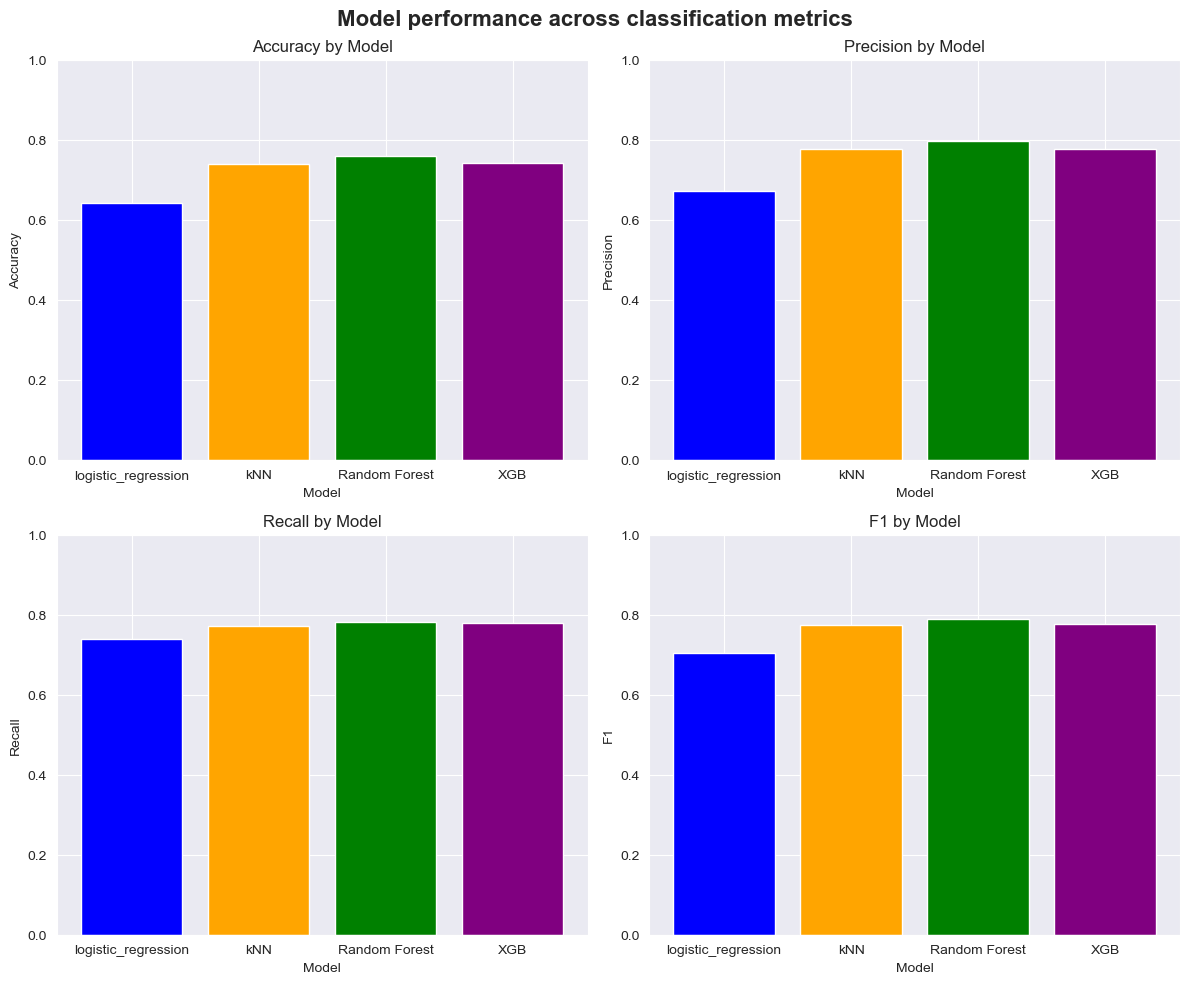

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes = axes.flatten()

# Titles for each subplot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

# Iterate over each performance metric and plot
for i, metric in enumerate(metrics):
    axes[i].bar(performance_df.index, performance_df[metric], color=['blue', 'orange', 'green','purple'])
    axes[i].set_title(f'{metric} by Model')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)  # Performance metrics usually range from 0 to 1
    axes[i].set_xlabel('Model')

# Add an overall title to the figure
fig.suptitle('Model performance across classification metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Accuracy from different models vs VEGA model')

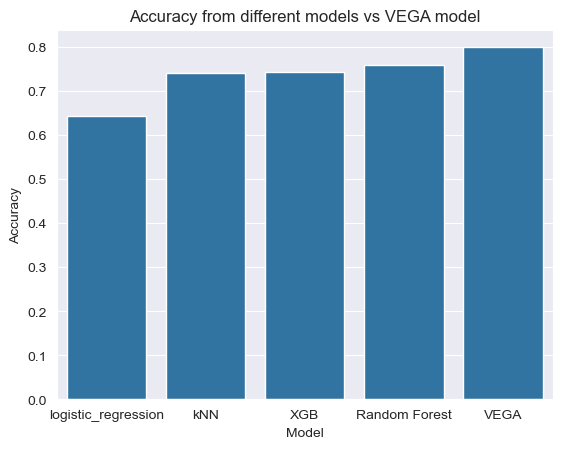

In [52]:
acc_df = performance_df['Accuracy']

acc_df.loc['VEGA'] = VEGA_accuracy
acc_df = acc_df.sort_values()
sns.barplot(acc_df)
plt.xlabel("Model")
plt.title("Accuracy from different models vs VEGA model")


After fitting 4 models and evaluating them on the most common classification metrics, the best performing model was Random Forest with an accuracy of 73.17% and an F1 score of 0.765. The XGB model closely followed with an accuracy of 72.49% and an F1 score of 0.763. While kNN showed some promising results, it came after these 2 models. Finally, Logistic Regression had the lowest performance with an accuracy of 65.81%.


Random Forest had its success due to its ability to handle data with a high number of dimensions, and non-linear relationships [8]. These are very common when handling molecular and atomic property data. Similarly, XGB also excelled in the performance metrics although its performance can be sensitive to the choice of hyperparameters [9]. As XGB is a modified random forest that uses gradient boosting instead of bagging, it makes sense its performance would be similar to its sister model. Usually, XHB outperforms random forests, however XGB is very sensitive to hyperparameter tuning. Seeing as this analysis only tuned 6 hyperparamters, with a deeper dive and further optimization, XGB should be able to outperform all other models [10].  

Furthermore, because of the random forest's structure, they are also very resistant to overfitting the data which might increase its accuracy when testing the data [8]. It is also very promising that all of the models had a very high recall. Since this model has the intention to be used as a predictor for mutagenic compounds, having a low probability of miscategorizing a mutagenic compound as one that is not is key in drug design. 

Given that this model will be used for human and environmental safety assessments, achieving even higher performance is critical. Although as a first excercise, 73% is an acceptable accuracy, it is vital to improve these metrics as the classification has huge safety implications. For future work, executing a deep dive into huperparameter tuning, enriching the dataset with more features such as thermodynamic and more physicochemical properties, molecular descriptors, and using cross-validation should be explored in the quest of model performance optimization. Another idea would be to explore feature selection. However, one of the drawbacks for random forests and XGB is that they sacrifice clarity and feature weight for performance and high robustness.

When comparing to the models tuned in this notebook with respect to the VEGA model, it clearly shows that more tuning is required as the VEGA model outperforms all proposed models in this notebook. The VEGA model achieved a 79% accuracy, 6% higher than the best performing models. One of the key features of this model is because they take advantage of the QSAR (Quantitative Structure-Activity Relationship) to have a better understanding of how compounds act [1]. If the data was further enriched by more molecular and atomic properties, especially ones relating to molecule structure and morphology, the models trained will have a better performance than shown in this notebook.

# Conclusion

Four different classification models were evaluated to detect the mutagenicity of different organic compounds. In this case, the best performing models were Random Forests and XGB with an accuracy of 73% and 72% respectively. These models had a promising accuracy and recall, which is vital in drug desing to avoid false negatives and missclassifying a safe compound when it is not. Although these models had very promising classification metrics, they still underperformed when compared to the VEGA model which had an accuracy of 79%. Further data enrichment and better hyperparameter tuning are suggested to increase the performance of these models in hope to match and surpass the VEGA model's metrics. 

# Bibliography

[1] A. Cassano et al., “Evaluation of QSAR models for the prediction of Ames Genotoxicity: A retrospective exercise on the chemical substances registered under the EU REACH regulation,” Journal of Environmental Science and Health, Part C, vol. 32, no. 3, pp. 273–298, Jul. 2014. doi:10.1080/10590501.2014.938955

[2] S. S. El Souda, “Mutagenesis and chemoprotective role of natural products,” Studies in Natural Products Chemistry, pp. 345–379, 2021. doi:10.1016/b978-0-12-819489-8.00012-0 

[3] J. R. Landolph, “Genetic toxicology,” Encyclopedia of Toxicology, pp. 421–432, 2005. doi:10.1016/b0-12-369400-0/00659-1 

[4] D. Clive, “Mutagenicity in drug development: Interpretation and significance of test results,” Regulatory Toxicology and Pharmacology, vol. 5, no. 1, pp. 79–100, Mar. 1985. doi:10.1016/0273-2300(85)90022-4 

[5] Melanie, “Classification algorithms: Definition and main models,” DataScientest, https://datascientest.com/en/classification-algorithms-definition-and-main-models (accessed Jul. 22, 2025). 

[6] K. P. Shung, “Accuracy, precision, recall or F1?,” Medium, https://medium.com/data-science/accuracy-precision-recall-or-f1-331fb37c5cb9 (accessed Jul. 22, 2025). 

[7] E. I. Sanchez Medina, A. del Rio Chanona, and C. Ganzer, Machine Learning in Chemical Engineering. JupyterBook, 2023. 

[8] L. Breiman, “Random forests,” Machine Learning, vol. 45, no. 1, pp. 5–32, Oct. 2001. doi:10.1023/a:1010933404324 

[9] Rithp, “Optimizing xgboost: A guide to hyperparameter tuning,” Medium, https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d (accessed Jul. 22, 2025). 

[10] D. kharkar, “Unravelling the power of xgboost: Boosting performance with extreme gradient boosting,” Medium, https://medium.com/@dishantkharkar9/unravelling-the-power-of-xgboost-boosting-performance-with-extreme-gradient-boosting-302e1c00e555 (accessed Jul. 22, 2025). 